In [1]:
import numpy as np
import numpy.random as npr
import scipy.stats as st
import scipy.special as sp
import pandas as pd
import itertools
from collections import Counter

import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sb
sb.set_color_codes()

In [2]:
X = pd.read_csv('data.txt', header=None).as_matrix()
print X.shape

(250, 2)


In [12]:
class EMGMM():
    def __init__(self, k):
        self.k = k
        
    def fit(self, X, T=100):
        N, d = X.shape
        r = np.min(X), np.max(X)
        
        # init values
        pi = st.dirichlet.rvs(np.ones(self.k)).reshape(-1)
        mus =  [ X[i] for i in npr.choice(range(N), size=self.k, replace=True)]
        precs = [ np.std(X, axis=0)*np.eye(d) for _ in range(self.k) ]

        # EM
        logps = []
        for t in range(T):
            # E step
            phis = [ pi[j]*st.multivariate_normal.pdf(X, mus[j], precs[j]) for j in range(self.k) ]
            Z = np.sum(np.vstack(phis), axis=0)
            phis = [ phi/Z for phi in phis ]
            
            # M step
            ns = [ np.sum(phi).astype(np.float32) for phi in phis ]
            mus = [ (1/n) * np.dot(phi, X) for n, phi in zip(ns, phis) ]
            precs = [ (1/n) * np.dot(phi * (X-mu).T, X-mu) for n, phi, mu in zip(ns, phis, mus) ]
            pi = [ n/N for n in ns ]
            
            # ln p(x|*)
            logps.append(np.sum([ pi[j] * st.multivariate_normal.pdf(X, mus[j], precs[j]) for j in range(self.k)]))
        
        # save everything
        self.N = N
        self.d = d
        self.pi = pi
        self.mus = mus
        self.precs = precs
        self.ns = ns
        self.logps = logps
            
    def predict(self, X):
        logps = np.vstack([ p * st.multivariate_normal.pdf(X, mu, prec) 
                           for p, mu, prec in zip(self.pi, self.mus, self.precs) ])
        labels = np.argmax(logps, axis=0)
        return labels

# Prob 1

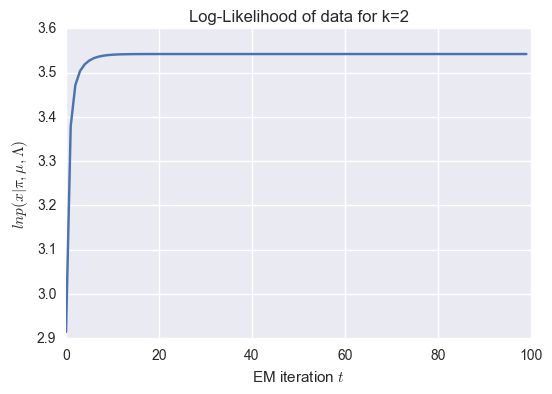

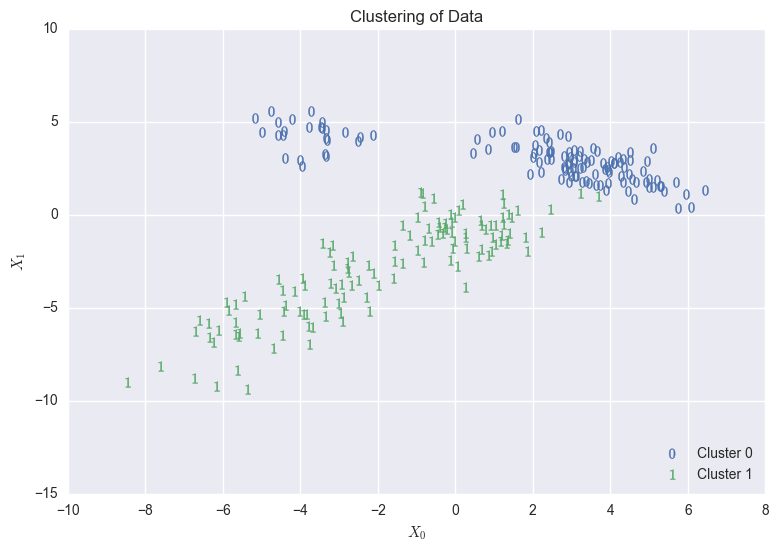

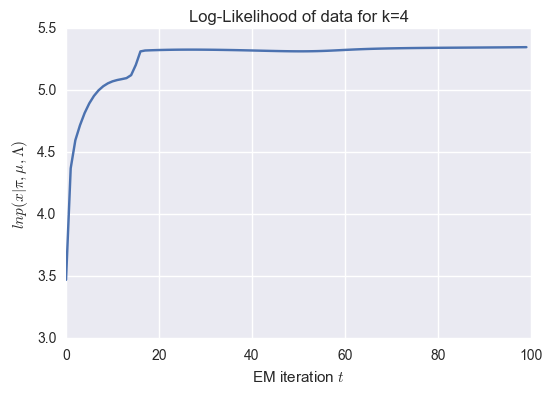

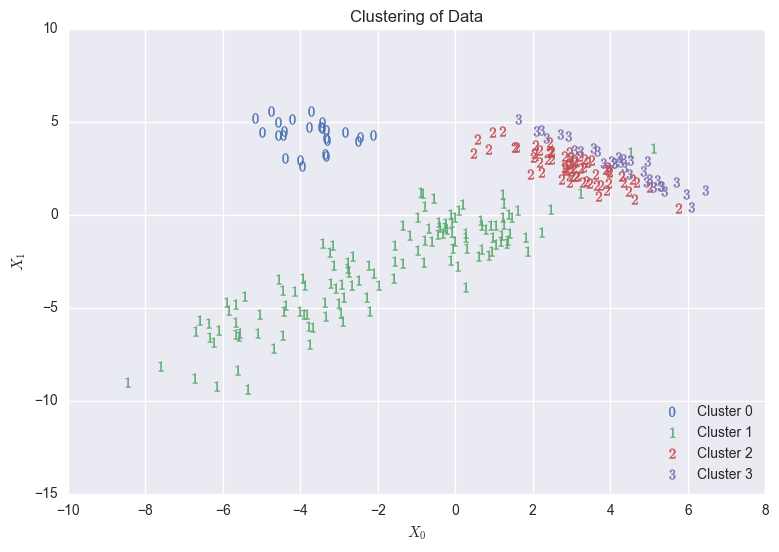

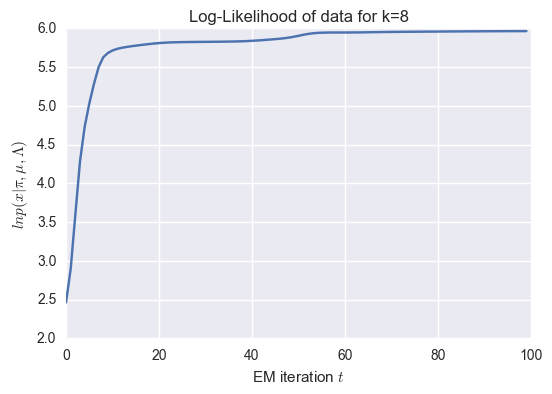

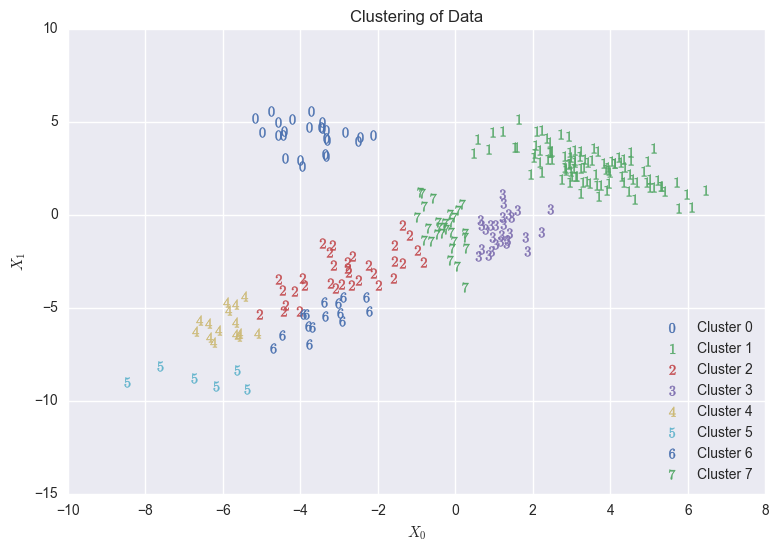

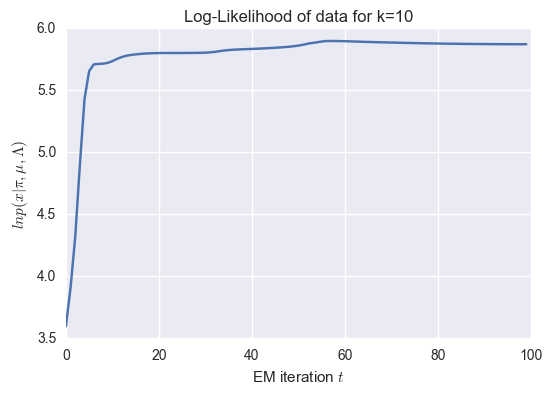

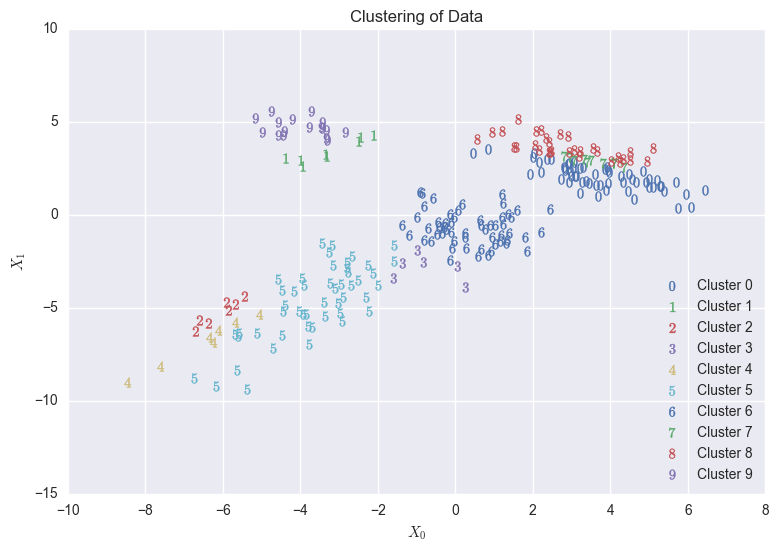

In [13]:
npr.seed(42)
for k in [2,4,8,10]:
    model = EMGMM(k=k)
    model.fit(X, T=100)
    labels = model.predict(X)
    
    # fit plot
    fig, ax = plt.subplots(1, figsize=(6,4))
    ax.plot(model.logps)
    ax.set_title("Log-Likelihood of data for k={}".format(k))
    ax.set_xlabel("EM iteration $t$")
    ax.set_ylabel("$ln p(x|\pi, \mu, \Lambda)$")
    fig.savefig("p1-{}-fit.pdf".format(k))
    
    # clustering plot
    fig, ax = plt.subplots(1, figsize=(9,6))
    colors = itertools.cycle(sb.color_palette("deep", n_colors=model.k))
    for i in range(model.k):
        c_i = X[labels == i]
        ax.scatter(c_i[:,0], c_i[:,1], color=next(colors), 
                    marker=r"${}$".format(i), s=50, alpha=1,
                    label="Cluster {}".format(i))
    ax.legend(loc=4)
    ax.set_title("Clustering of Data")
    ax.set_xlabel(r"$X_0$")
    ax.set_ylabel(r"$X_1$")
    fig.savefig("p1-{}-data.pdf".format(k))

In [25]:
class VariationalGMM():
    def __init__(self, k):
        self.k = k
        
    def fit(self, X, T=100):
        print "Fitting for {} iterations...".format(T),
        N, d = X.shape
        r = np.min(X), np.max(X)
        
        # init const values
        alpha = 1
        c = 10.  
        cinvI = (1/c)*np.eye(d)
        a = d
        A = np.cov(X.T)
        B = (d/10.) * A
        
        # init variational params
        alphas = [ 1. for _ in range(self.k) ]
        ms = [ X[i] for i in npr.choice(range(N), size=self.k, replace=True)]
        sigmas = [ np.std(X, axis=0)*np.eye(d) for _ in range(self.k) ]
        as_ = [ d for _ in range(self.k) ]
        Bs = [ (d/10.) * A for _ in range(self.k) ]
        
        fits = []
        for t in range(T):
            E_Lambdas = [ np.dot(as_[j], np.linalg.inv(Bs[j])) for j in range(self.k) ]
            
            # update q(c)
            t1s = [ np.sum( [sp.digamma(.5*(1-k+as_[j])) for k in range(d)] ) - np.log(np.linalg.det(Bs[j])) 
                    for j in range(self.k) ] 
            t2s = [ np.sum(np.dot(X-ms[j], E_Lambdas[j]) * (X-ms[j]), axis=1)
                    for j in range(self.k)]
            t3s = [ np.trace(np.dot(E_Lambdas[j], sigmas[j])) 
                    for j in range(self.k) ]
            t4s = [ sp.digamma(alphas[j]) - sp.digamma(np.sum(alphas)) 
                    for j in range(self.k)]
    
            phis = [ np.exp(.5*(t1s[j] - t2s[j] - t3s[j]) + t4s[j]) 
                     for j in range(self.k)]
            Z = np.sum(phis, axis=0)
            phis =  [ phi/Z for phi in phis ]
            
            # update ns
            ns = [ np.sum(phi) for phi in phis ]
            
            # update q(pi)
            alphas = [ alpha + n for n in ns ]
            
            # update q(mu)
            sigmas = [ np.linalg.inv(cinvI + ns[j]*E_Lambdas[j]) 
                       for j in range(self.k) ]
            ms = [ np.dot(sigmas[j], np.dot(E_Lambdas[j], np.dot(phis[j], X)))
                   for j in range(self.k) ]

            # update q(Lambda)
            as_ = [ a + n for n in ns ]
            Bs = [ B + np.sum(np.array([ phis[j][i] * (np.outer(X[i]-ms[j], X[i]-ms[j])+ sigmas[j])
                                        for i in range(N)]), axis=0)
                   for j in range(self.k)]
            
            # variational objective
            fit = 0
            for i in range(N):
                for j in range(self.k):
                    fit += phis[j][i] * (.5 * (t1s[j] - t2s[j][i] - t3s[j]) + t4s[j])
            fit += np.sum([ (alpha -1.) * (sp.digamma(alphas[j]) - sp.digamma(np.sum(alphas)))
                            for j in range(self.k) ])
            fit -= np.sum([ np.dot(ms[j], ms[j]) + np.trace(sigmas[j]) for j in range(self.k)])
            fit -= np.sum([ t1s[j] + np.trace(np.dot(Bs[j], as_[j] * np.linalg.inv(Bs[j])))
                            for j in range(self.k) ])
            fit += st.dirichlet.entropy(alphas)
            fit += np.sum([ st.multivariate_normal.entropy(cov=sigmas[j]) for j in range(self.k) ])
            fit += np.sum([ st.wishart.entropy(as_[j], Bs[j]) for j in range(self.k)])
#             print "T={}, L={}".format(t, fit)
            fits.append(fit)
        print "Done"
        
        # save values
        self.fits = fits
        self.alphas = alphas
        self.ms = ms
        self.sigmas = sigmas
        self.as_ = as_
        self.Bs = Bs
        
    def predict(self, X):
        N, d = X.shape
        # calculate q(c_i)
        E_Lambdas = [ np.dot(self.as_[j], np.linalg.inv(self.Bs[j])) for j in range(self.k) ]
        E_logdet_Lambdas = [ d*np.log(2) - np.log(np.linalg.det(self.Bs[j]))
                             + np.sum([.5*(sp.digamma(self.as_[j]) + 1 - i) for i in range(d)])
                             for j in range(self.k)]
        Z = np.sum(self.alphas)
        E_ln_pi = [ sp.digamma(self.alphas[j]) - sp.digamma(Z) for j in range(self.k) ]
        E_mT_Lamb_m = [ np.sum(np.dot(X-self.ms[j], E_Lambdas[j]) * (X-self.ms[j]), axis=1)
                        + np.trace(np.dot(E_Lambdas[j], self.sigmas[j]))
                        for j in range(self.k) ]
        q_cj = np.vstack([ np.exp(.5*(E1 - E2) + E3)
                 for E1, E2, E3 in zip(E_logdet_Lambdas, E_mT_Lamb_m, E_ln_pi)]).T
        Z = np.sum(q_cj, axis=1)
        q_cj = np.array([ q_cj[:,j] / Z for j in range(self.k)]).T
        return np.argmax(q_cj, axis=1)
        

Fitting for 100 iterations... Done
Fitting for 100 iterations... Done
Fitting for 100 iterations... Done
Fitting for 100 iterations... Done


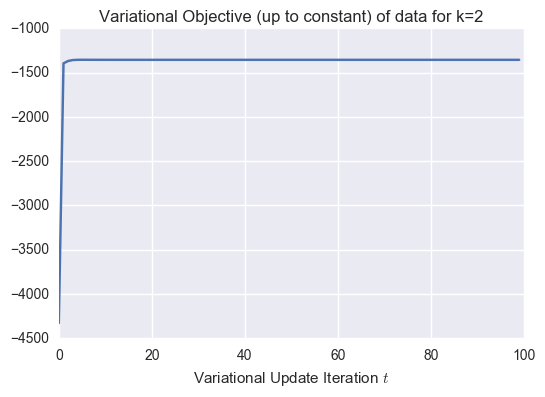

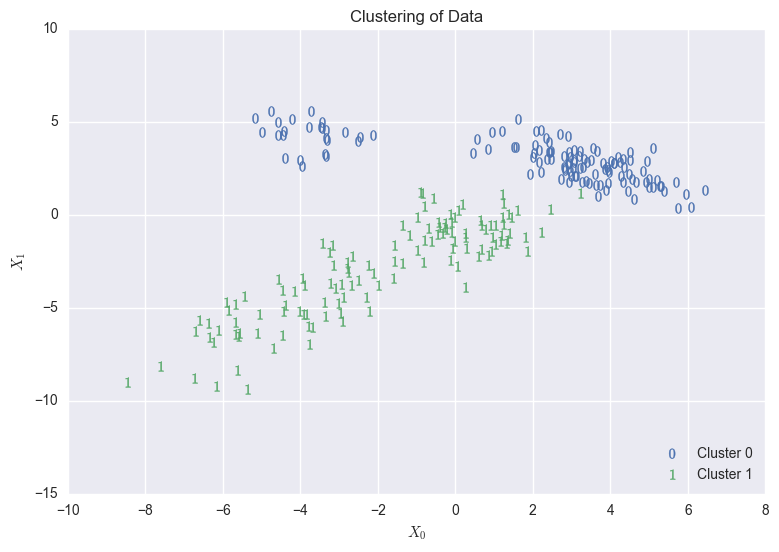

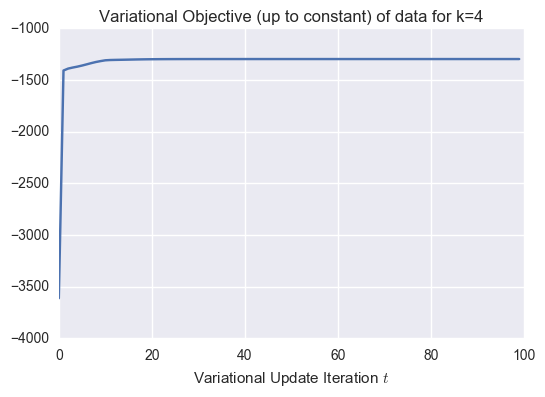

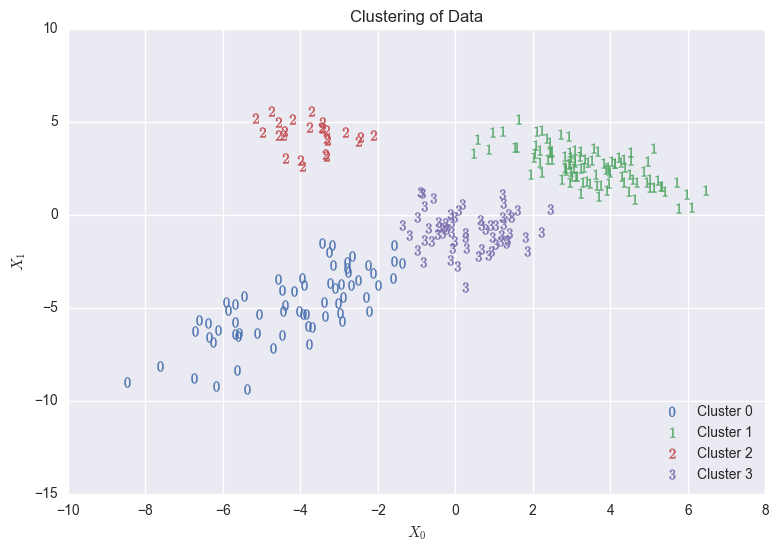

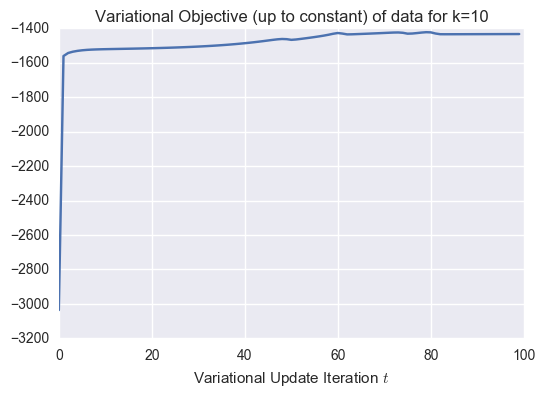

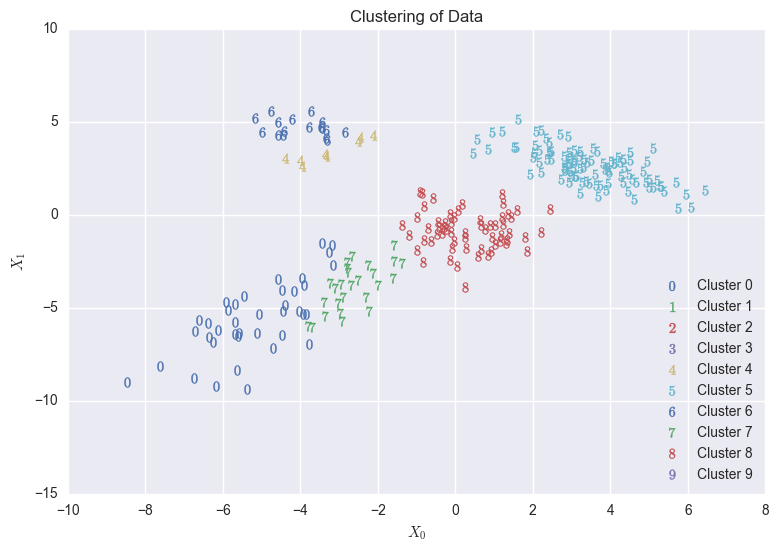

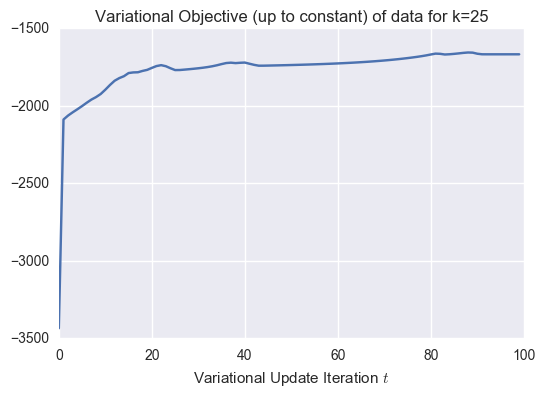

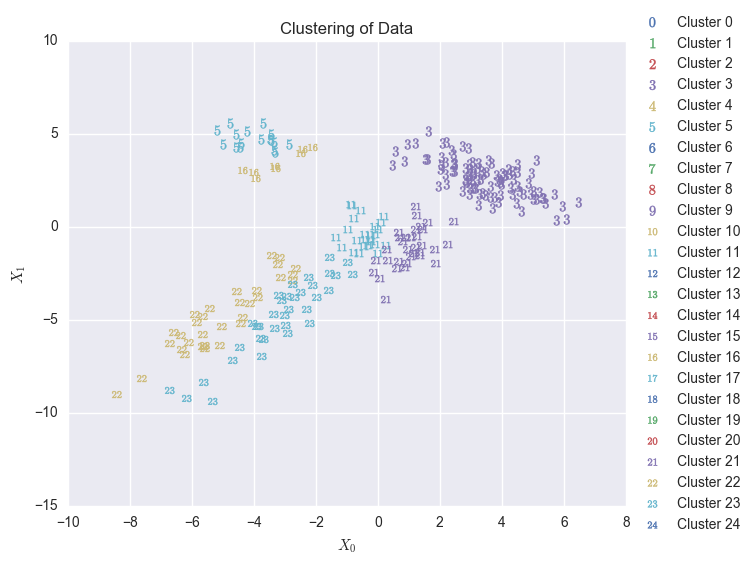

In [27]:
npr.seed(42)
for k in [2,4,10,25]:
    model = VariationalGMM(k=k)
    model.fit(X, T=100)
    labels = model.predict(X)
    
    # fit plot
    fig, ax = plt.subplots(1, figsize=(6,4))
    ax.plot(model.fits)
    ax.set_title("Variational Objective (up to constant) of data for k={}".format(k))
    ax.set_xlabel("Variational Update Iteration $t$")
#     ax.set_ylabel("$")
    fig.savefig("p2-{}-fit.pdf".format(k))
    
    # clustering plot
    fig, ax = plt.subplots(1, figsize=(9,6))
    colors = itertools.cycle(sb.color_palette("deep", n_colors=model.k))
    for i in range(model.k):
        c_i = X[labels == i]
        ax.scatter(c_i[:,0], c_i[:,1], color=next(colors), 
                    marker=r"${}$".format(i), s=50, alpha=1,
                    label="Cluster {}".format(i))
    if k == 25:
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend(loc=4)
    ax.set_title("Clustering of Data")
    ax.set_xlabel(r"$X_0$")
    ax.set_ylabel(r"$X_1$")
    fig.savefig("p2-{}-data.pdf".format(k))

In [28]:
class GibbsDPGMM():
    def fit(self, X, T=500, alpha=1.):
        # inits
        N, d = X.shape
        a = d
        c = .1
        m = np.mean(X, axis=0)
        B = c * d * np.cov(X.T)
        cs = [0]*N
        ns = [len([ci for ci in cs if ci == i]) for i in range(max(cs)+1)]
        sigmas = [st.wishart.rvs(a, B)]
        mus = [st.multivariate_normal.rvs(m, np.linalg.inv(c * sigmas[0]))]
        p = lambda x, mu, sigma: st.multivariate_normal.pdf(x, mu, sigma)
        self.cluster_sizes = {i:[] for i in range(6)}
        self.ks = []
        
        # setup to calculate marginals
        prefix = (c/(np.pi*(c+1)))**(d/2.)
        gam_ratio = np.exp(np.sum([sp.gammaln(.5*(a-j)+1) - sp.gammaln(.5*(a-j+1)) for j in range(d)]))
        denom = np.linalg.det(B)**(-a/2.)
        coef = prefix * gam_ratio / denom
        marginal = lambda x: coef * np.linalg.det(B+(c/(1+c))*np.outer(x-m, x-m))**(-.5*(a+1))
        
        # setup to sample mu and sigma given xs in cluster
        def sample_theta(xs):
            s = xs.shape[0]
            xbar = np.mean(xs, axis=0)
            aprime = a + s
            Bprime = B
            Bprime += np.sum([np.outer(xi-xbar, xi-xbar) for xi in xs])
            Bprime += (s/(a*s+1))*np.outer(xbar-m, xbar-m)
            sigma = st.wishart.rvs(aprime, Bprime)
            cprime = c + s
            mprime = (c*m + np.sum(xs, axis=0))/(s+c)
            mu = st.multivariate_normal.rvs(mprime, np.linalg.inv(cprime * sigma))
            return mu, sigma
            
        # run the gibbs sampler
        for t in range(T):
            # sample cluster assignments
            for i, xi in enumerate(X):
                # 1(a) calculate current cluster scores
                ns[cs[i]] -= 1
                
                # check if we are destroying a cluster
                if ns[cs[i]] == 0:
                    # if we are, then forget the params of this cluster
                    ci = cs[i]
                    ns = [ n for j, n in enumerate(ns) if j != ci ]
                    mus = [ mu for j, mu in enumerate(mus) if j != ci ]
                    sigmas = [ sigma for j, sigma in enumerate(sigmas) if j != ci ]
                    # and drop the index of all clusters above it by 1
                    cs = [ cj-1 if cj > ci else cj for cj in cs ]
                    
                phis = [ p(xi, mus[j], sigmas[j])*ns[j]/(N+alpha-1) 
                         for j in range(len(ns)) if ns[j] > 0 ]
                
                # 1(b) calculate new cluster score
                phis.append(marginal(xi)*alpha/(alpha+N-1))
                
                # 1(c) normalize and sample cluster assignment
                Z = np.sum(phis)
                phis = np.array(phis)/Z
                ci = npr.choice(range(len(phis)), size=1, p=phis)[0]
                cs[i] = ci
                
                # check if we are creating a cluster
                if ci == (len(phis)-1):
                    # if we are, sample new params
                    mu, sigma = sample_theta(xi)
                    mus.append(mu)
                    sigmas.append(sigma)
                    ns.append(0)
                
                # (re)increment the count
                ns[cs[i]] += 1
            
            # sample cluster params
            k = len(set(cs))
            self.ks.append(k)
            print "\rT={}, K={}".format(t,k),
            for i in range(k):
                xs = X[np.array(cs) == i]
                mu, sigma = sample_theta(xs)
                mus[i] = mu
                sigmas[i] = sigma
                
            # check out the cluster sizes
            for i, (_, v) in enumerate(Counter(cs).most_common(6)):
                self.cluster_sizes[i].append(v)
            while i < 5:
                i += 1
                self.cluster_sizes[i].append(0)


In [29]:
model3 = GibbsDPGMM()
model3.fit(X)

T=499, K=3


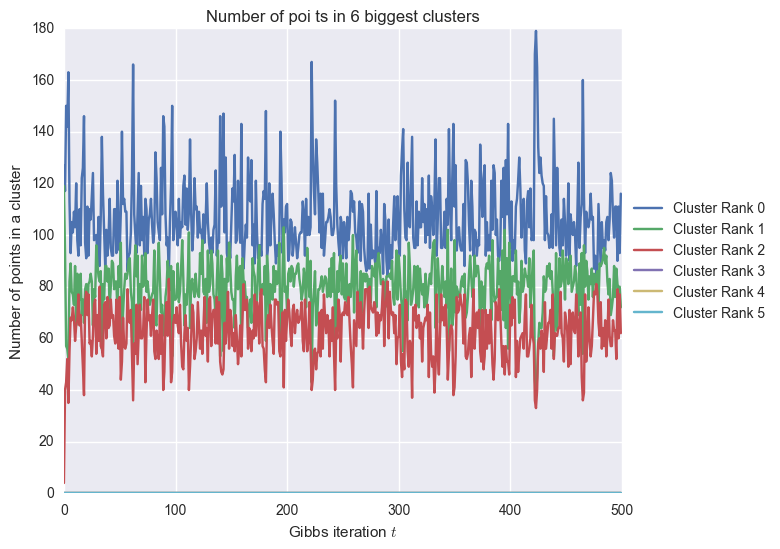

In [32]:
fig, ax = plt.subplots(1, figsize=(9,6))
for i, sizes in model3.cluster_sizes.items():
    ax.plot(sizes, label="Cluster Rank {}".format(i))
# ax.legend()
ax.set_title("Number of poi ts in 6 biggest clusters")
ax.set_xlabel("Gibbs iteration $t$")
ax.set_ylabel("Number of points in a cluster")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig('p3-cluster-sizes.pdf')

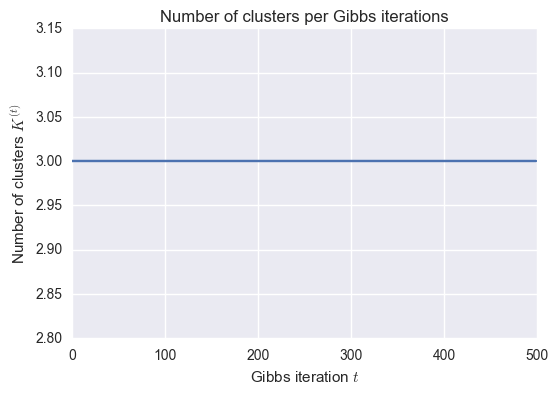

In [33]:
fig, ax = plt.subplots(1, figsize=(6,4))
ax.plot(model3.ks)
# ax.legend()
ax.set_title("Number of clusters per Gibbs iterations")
ax.set_xlabel("Gibbs iteration $t$")
ax.set_ylabel("Number of clusters $K^{(t)}$")
fig.savefig('p3-num-clusters.pdf')